## Towards a more intutive understanding of overrepresentation analysis for Biology 


**General motivation:**

Pathway enrichment analysis or in more general term overrepresentation analysis is quite widespread in Biology. We frequently end up with lists of genes, transcripts, genomic regions, etc and want to find out what general signatures/pathways/transcription factor binding motifs are enriched therein. Statistically speaking overrepresentation analysis is performed by a hypergeometric test or it's close relative the Fisher's exact test. The formulas for calculating probabilities and p-values are listed below but they are not that easy to intuitively understand. 

The goal of this notebooks is to provide some interactive tools to enable a better understanding how each component of the enrichment analysis (size of overlap, size of gene sets, etc) relates to each other and how this influences the outcome p-value.

This goal of this notebook is NOT to provide a comprehensive explanation of the statistical foundations of the tests used. Statistical precision is deliberately omitted in order to provide more clarity for the biological audience. I highly recommend the Wikipedia page for a more in depth but very clearly explained discussion of the [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) as well as the [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution).


In [2]:
#load some packages that are needed for plotting + computation

import math
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
import pandas as pd
import scipy.stats as stats

### 1) Define the input variables

First let's define the size of the an arbitrary result, that could have been obtained from a typical RNAseq experiment. We have a certain number of genes that are upregulated (Genes_up). We have a specific GO term (Genes_GO) that consists of a certain number of genes and there is an overlap of Genes that are both part of the GO term and part of the upregulated genes (upAndGO). Finally we also must set the total number of Genes that we observed. For example this could be the total number of genes that are expressed in my sample (universe). 

In [38]:
# define Variables
Genes_up = 200 # genes that are upregulated 
Genes_GO = 50 # genes that are part of a specific GO term
upAndGO = 10 # upregulated genes that are part of that GO term (==overlap)
universe = 10000 # total number of genes that could be observed

### 2) Visualize the overlap as a 2x2 table

The overlap and relation between the two groups (GO term and Genes up) can be visualized by a 2x2 table. The top left contains the genes that are a member of both classes. 

| . |  genes up  | genes not up | total |
| --------- | ---------- | ------------ |---------- |
| GO yes |  **a** (upAndGO)  | **b** | Genes_GO |
| GO no |  **c** | **d** | |
| GO yes | Genes_up |  .  | universe |

All the rows add up accross and the columns add up vertically. For the calculations we only need the inner values a-d. They are caluculated for our example below


In [39]:
# calculate all the parts of the 2x2 table and plot it
a = upAndGO
b = Genes_GO - upAndGO
c = Genes_up - upAndGO
d = universe - (b+c+a)

table = pd.DataFrame(np.array([[a, b, Genes_GO], [c, d, (c+d)], [Genes_up, (b+d), universe]]),
                    columns=['genes up', 'genes not up', 'total'], index = ['GO yes', 'GO no', 'total'])
table

,genes up,genes not up,total
GO yes,10,40,50
GO no,190,9760,9950
total,200,9800,10000


### 3) Visualize the overlap as a Venn diagram

similarily we can also visualize the overlap with a Venn diagram where the size is proportional to each of the values

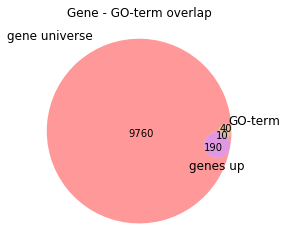

In [40]:
# this plots a Venn diagram

plt.figure(figsize=(4,4))
v = venn3((d , 0, b, 0, c, 0, a), set_labels = ('gene universe', 'GO-term', 'genes up'))
plt.title("Gene - GO-term overlap")
plt.show()

### 4) Calculate the probablity of obtaining this specific result

With the following formula for the hypergeometric distribution you can calculate the exact probablity of getting the result (overlap) shown above. As mentioned before - not that easy to understand how probablity would change based on a different relation of a to b to c to d.

$probablity=\frac{\left(\begin{array}{c}{a+b} \\ {a}\end{array}\right)\left(\begin{array}{c}{c+d} \\ {c}\end{array}\right)}{\left(\begin{array}{c}{n} \\ {a+c}\end{array}\right)}=\frac{\left(\begin{array}{c}{a+b} \\ {b}\end{array}\right)\left(\begin{array}{c}{c+d} \\ {d}\end{array}\right)}{\left(\begin{array}{c}{n} \\ {b+d}\end{array}\right)}=\frac{(a+b) !(c+d) !(a+c) !(b+c) !(b+d) !}{a ! b ! c ! d ! n !}$

In [43]:
prob = math.factorial(a+b)*math.factorial(c+d)*math.factorial(a+c)*math.factorial(b+d)/(math.factorial(a)*math.factorial(b)*math.factorial(c)*math.factorial(d)*math.factorial(universe))
print('The probablity of getting this distribution is %s' %(prob))

The probablity of getting this distribution is 3.893900487692668e-08


The probablity is shown above but again this is only the probablity of that specific 2x2 table.

### 5) The actual p-value = probablity of this result + anything more extreme than that

In practice the p-value of the one-tailed Fisher exact (or hypergeometric) test does not only take into account the probablity of one specific 2x2 table but it also adds the probabilites of all tables that are more "extreme" than that. In this particular case more extreme would mean more genes that overlap by being in category 'a'. The p-value represents chance of getting a result so 'extreme' as in the 2x2 table or even more extreme. If it is very small (typical cutoff 0.05) we can reject the null hypothesis and call the result statistically significant. In other words there is a significant overlap of the number of genes that are upregulated and the number of genes that are a member of the GO term. Therefore we can call this pathway enriched in our gene set.

In [10]:
oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]])
pvalue

4.1878916374966034e-08

In this case the p-value is <0.05 so this overlap is statistically significant. 

### 6) Try it out yourself - different permutations

Here is the whole above analysis in one cell. Feel free to play around and see how p-values change. 

        genes up  genes not up  total
GO yes        10            40     50
GO no        190          9760   9950
total        200          9800  10000


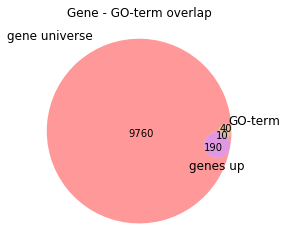

The p-value for the one tailed Fisher exact test is 4.1878916374966034e-08


In [48]:
# define Variables
Genes_up = 200
Genes_GO = 50
upAndGO = 10
universe = 10000

# calculate the parts
a = upAndGO
b = Genes_GO - upAndGO
c = Genes_up - upAndGO
d = universe - (b+c+a)

# this makes the table
table = pd.DataFrame(np.array([[a, b, Genes_GO], [c, d, (c+d)], [Genes_up, (b+d), universe]]),
                    columns=['genes up', 'genes not up', 'total'], index = ['GO yes', 'GO no', 'total'])
print(table)

#this makes the Venn diagramm
plt.figure(figsize=(4,4))
v = venn3((d , 0, b, 0, c, 0, a), set_labels = ('gene universe', 'GO-term', 'genes up'))
plt.title("Gene - GO-term overlap")
plt.show()

#calculating the P-value
oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]], alternative='greater')

print('The p-value for the one tailed Fisher exact test is %s' %(pvalue))

### 7) How does the p-value change when one parameter is varied

The above cell allow nicely to play around with the different parameters but only one result can be looked at at a time. Below I plotted how the p-value cahgnes when one parameter (size of overlap, size of universe, size of GO term) is varied and everything else is kept constant.

#### a) stepwise increases of the GO-term size
replacing the GO-term with the upregulated Genes will give a similar result

<function matplotlib.pyplot.show(*args, **kw)>

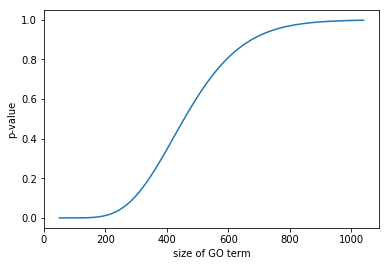

In [25]:
# define Variables
Genes_up = 200
Genes_GO = 50 # start with a small size
upAndGO = 10 
universe = 10000

# calculate the parts - do not need to calculate b here because that is the parmeter that is varied in the loop
a = upAndGO
c = Genes_up - upAndGO
d = universe - (b+c+a)

# define a Dataframe where the results are saved
results_df=[]
results_df = pd.DataFrame(columns=['size_GO', 'p-value', 'oddsratio'])

for i in range(Genes_GO, Genes_GO+1000, 10):
    b = i - upAndGO
    oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]], alternative='greater')
    results_df = results_df.append(pd.DataFrame([[i, pvalue, oddsratio]], columns=['size_GO', 'p-value', 'oddsratio']))

# plot the p-value how it depends on the size of the GO term
plt.plot(results_df['size_GO'], results_df['p-value'])
plt.xlabel('size of GO term')
plt.ylabel('p-value')
plt.show

**Conclusion**: Increasing the size of the GO term will increase the p-value and the overlap will be less statistically significant. If most of the genes are part of the GO-term then it's more likely that the overlap is due to random chance. Conversely smaller GO terms will "reach significance" more easliy even if only a couple of genes are overlapping.

#### b) stepwise increases of the overlap size

<function matplotlib.pyplot.show(*args, **kw)>

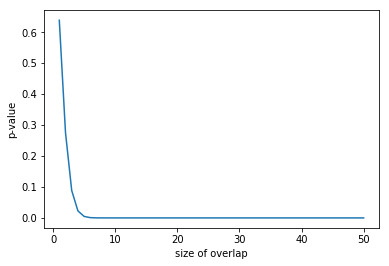

In [30]:
# define Variables
Genes_up = 200
Genes_GO = 50 
upAndGO = 1 # start with a small size (can only be as big as the Genes_up or Genes_GO)
universe = 10000

# calculate the parts - do not need to calculate a here because that is the parmeter that is varied in the loop

b = Genes_GO - upAndGO
c = Genes_up - upAndGO
d = universe - (b+c+a)

# define a Dataframe where the results are saved
results_df=[]
results_df = pd.DataFrame(columns=['size_overlap', 'p-value', 'oddsratio'])

for i in range(upAndGO, upAndGO+Genes_GO, 1):
    a = i
    oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]], alternative='greater')
    results_df = results_df.append(pd.DataFrame([[i, pvalue, oddsratio]], columns=['size_overlap', 'p-value', 'oddsratio']))

# plot the p-value how it depends on the size of the GO term
plt.plot(results_df['size_overlap'], results_df['p-value'])
plt.xlabel('size of overlap')
plt.ylabel('p-value')
plt.show

**Conclusion**: Increasing the size of the overlap will decrease the p-value and the overlap will be more statistically significant. That should be pretty intutive.

#### c) stepwise increases of the gene universe size

<function matplotlib.pyplot.show(*args, **kw)>

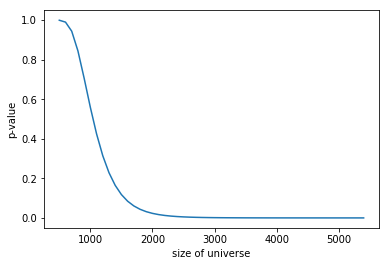

In [44]:
# make loop to vary the size of the Gene universe, while keeping everything else constant

# define Variables
Genes_up = 200
Genes_GO = 50
upAndGO = 10
universe = 500 # start with a small size

# calculate the parts - do not need to calculate d here because that is the parameter that is varied in the loop
a = upAndGO
b = Genes_GO - upAndGO
c = Genes_up - upAndGO

results_df=[]
results_df = pd.DataFrame(columns=['size_of_universe', 'p-value', 'oddsratio'])

for i in range(universe, universe+5000, 100):
    d = i - (b+c+a)
    oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]], alternative='greater') # 'greater' option means the probablity of having an overlap this big or greater, given the null hypothesis is true
    results_df = results_df.append(pd.DataFrame([[i, pvalue, oddsratio]], columns=['size_of_universe', 'p-value', 'oddsratio']))

# plot the top value for each cluster

plt.plot(results_df['size_of_universe'], results_df['p-value'])

plt.xlabel('size of universe')
plt.ylabel('p-value')
plt.show

**Conclusion**: Increasing the size of the gene universe will decrease the p-value and the overlap will be more statistically significant. If there are more genes to choose from then it is not as likely that they are overlapping.